In [8]:
import sys, os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

import pandas as pd, numpy as np, os
import seaborn as sns, matplotlib.pyplot as plt
from src.utils.config_loader import load_config

plt.style.use("seaborn-v0_8")
sns.set_palette("Greens_r")

# Load paths from YAML
cfg = load_config("../config/paths.yaml")["paths"]

# Make sure all paths are absolute relative to the repo root
repo_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
processed_dir = os.path.join(repo_root, cfg["processed_data_dir"])

# Locate merged dataset file
merged_path = os.path.join(processed_dir, "merged_customer_data.csv")

if not os.path.exists(merged_path):
    # Debugging output to help trace issues
    print("❌ File not found at:", merged_path)
    print("📂 Files available in processed_dir:", os.listdir(processed_dir))
    raise FileNotFoundError("Merged file missing. Please verify filename and location.")
else:
    df = pd.read_csv(merged_path)
    print(f"✅ Loaded dataset: {df.shape} from {merged_path}")
    display(df.head(3))





✅ Loaded dataset: (147896, 45) from /home/swateya_gupta/2/data/processed/merged_customer_data.csv


,account_id,account_name,industry,country,signup_date,referral_source,account_plan_tier,account_seats,account_is_trial,account_churn_flag,...,satisfaction_score,escalation_flag,churn_event_id,churn_date,reason_code,refund_amount_usd,preceding_downgrade_flag,preceding_upgrade_flag,is_reactivation,feedback_text
0,A-2e4581,Company_0,EdTech,US,2024-10-16,partner,Basic,9,0,0,...,3.0,0.0,C-695fcd,2024-11-23,budget,0.0,0.0,0.0,0.0,switched to competitor
1,A-2e4581,Company_0,EdTech,US,2024-10-16,partner,Basic,9,0,0,...,3.0,0.0,C-cea92d,2024-12-05,competitor,0.0,0.0,1.0,0.0,NaN
2,A-2e4581,Company_0,EdTech,US,2024-10-16,partner,Basic,9,0,0,...,NaN,0.0,C-695fcd,2024-11-23,budget,0.0,0.0,0.0,0.0,switched to competitor


In [9]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# -----------------------------------------------------------
# 1️⃣ Clean up missing data
# -----------------------------------------------------------
df = df.fillna({
    "feedback_text": "none",
    "reason_code": "none",
    "satisfaction_score": 0,
    "resolution_time_hours": 0,
    "first_response_time_minutes": 0,
    "refund_amount_usd": 0,
    "error_count": 0,
    "usage_count": 0,
    "usage_duration_secs": 0
})

# Ensure numeric columns are proper dtype
num_cols = df.select_dtypes(include=["object"]).columns
for col in ["account_churn_flag", "account_is_trial", "downgrade_flag",
            "upgrade_flag", "preceding_downgrade_flag", "preceding_upgrade_flag"]:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce").fillna(0).astype(int)

# -----------------------------------------------------------
# 2️⃣ Derived Feature Creation
# -----------------------------------------------------------
df["usage_efficiency"] = df["usage_count"] / (df["error_count"] + 1)
df["activity_intensity"] = np.log1p(df["usage_count"] * df["usage_duration_secs"])

df["refund_ratio"] = df["refund_amount_usd"] / (df["arr_amount"] + 1)
df["refund_satisfaction_gap"] = df["refund_amount_usd"] * (5 - df["satisfaction_score"])

df["support_efficiency"] = df["satisfaction_score"] / (df["resolution_time_hours"] + 1)
df["response_efficiency"] = df["satisfaction_score"] / (df["first_response_time_minutes"] + 1)

df["industry_country_combo"] = df["industry"] + "_" + df["country"]
df["industry_plan_combo"] = df["industry"] + "_" + df["subscription_plan_tier"]

df["trial_flag"] = df["account_is_trial"]

df = df.replace([np.inf, -np.inf], 0)

print(f"✅ Engineered features created. Current shape: {df.shape}")


✅ Engineered features created. Current shape: (147896, 54)


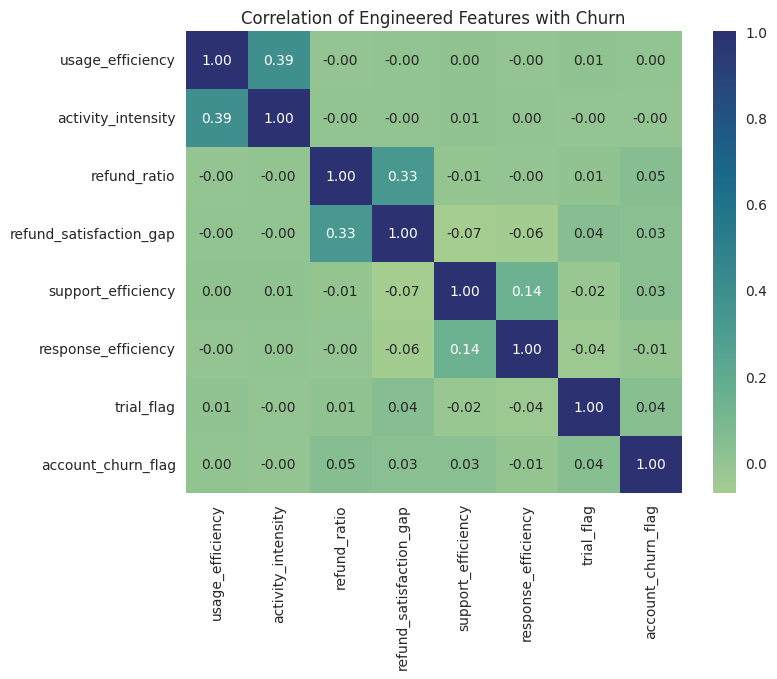

In [10]:
corr_features = [
    "usage_efficiency","activity_intensity","refund_ratio","refund_satisfaction_gap",
    "support_efficiency","response_efficiency","trial_flag"
]

plt.figure(figsize=(8,6))
sns.heatmap(df[corr_features + ["account_churn_flag"]].corr(),
            annot=True, cmap="crest", fmt=".2f")
plt.title("Correlation of Engineered Features with Churn")
plt.show()


🧮 Quick Sanity Model (XGBoost) to Test Feature Value

In [11]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

X = pd.get_dummies(df[corr_features + ["industry_country_combo","industry_plan_combo"]])
y = df["account_churn_flag"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

model = XGBClassifier(eval_metric="auc", use_label_encoder=False)
model.fit(X_train, y_train)

roc = roc_auc_score(y_val, model.predict_proba(X_val)[:,1])
print(f"✅ Validation ROC-AUC (sanity check): {roc:.3f}")


/home/swateya_gupta/miniconda3/envs/myenv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [22:10:30] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ Validation ROC-AUC (sanity check): 0.963


🔎 Highly correlated (>0.85) features: []


/home/swateya_gupta/miniconda3/envs/myenv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [22:12:22] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


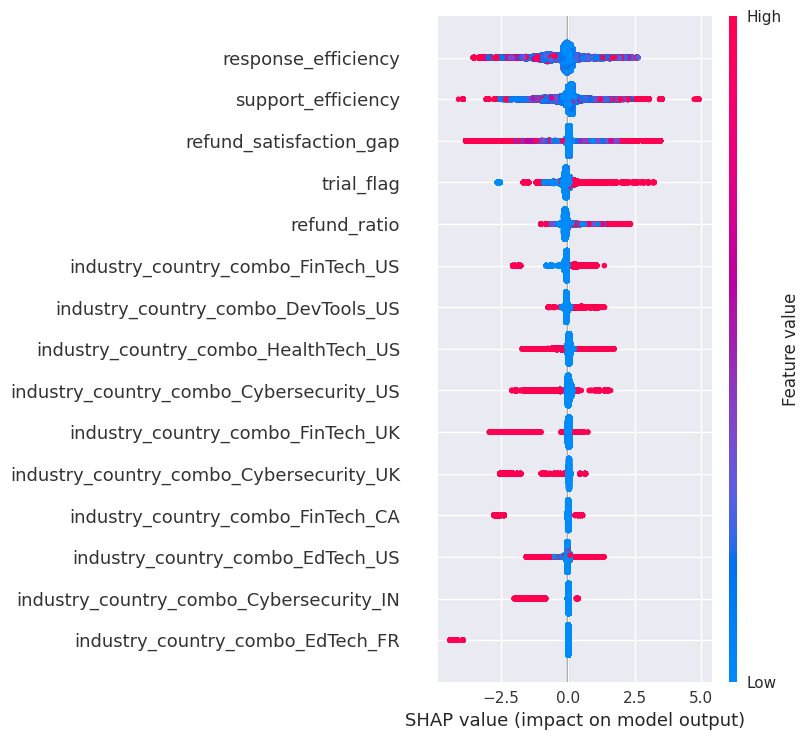

In [12]:
import shap
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier

# ==============================================================
# 1️⃣ Feature redundancy pruning
# ==============================================================
corr_matrix = df[corr_features].corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
redundant_features = [column for column in upper.columns if any(upper[column] > 0.85)]

print("🔎 Highly correlated (>0.85) features:", redundant_features)
X_reduced = df[corr_features].drop(columns=redundant_features, errors='ignore')

# ==============================================================
# 2️⃣ Train compact model for SHAP importance
# ==============================================================
y = df["account_churn_flag"]
X_dummies = pd.get_dummies(
    pd.concat([X_reduced, df[["industry_country_combo","industry_plan_combo"]]], axis=1),
    drop_first=True
)

scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_dummies), columns=X_dummies.columns)

model = XGBClassifier(eval_metric="auc", use_label_encoder=False, random_state=42)
model.fit(X_scaled, y)

# ==============================================================
# 3️⃣ SHAP Explainability
# ==============================================================
explainer = shap.Explainer(model)
shap_values = explainer(X_scaled)

shap.summary_plot(shap_values, X_scaled, max_display=15)


/tmp/ipykernel_90832/1671762943.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="importance", y="feature", data=importance_df.head(15), palette="Greens_r")


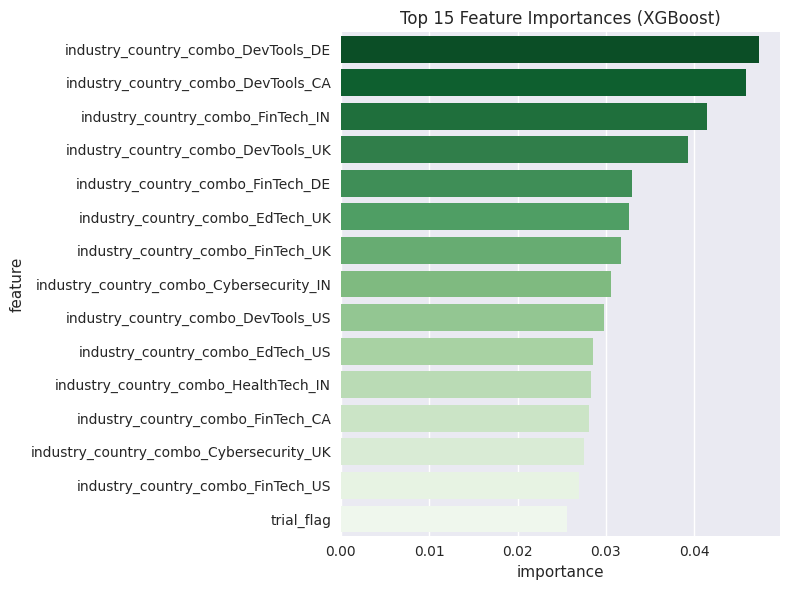

In [13]:
importance_df = pd.DataFrame({
    "feature": X_scaled.columns,
    "importance": model.feature_importances_
}).sort_values("importance", ascending=False)

plt.figure(figsize=(8,6))
sns.barplot(x="importance", y="feature", data=importance_df.head(15), palette="Greens_r")
plt.title("Top 15 Feature Importances (XGBoost)")
plt.tight_layout()
plt.show()


In [17]:
import pandas as pd
import numpy as np
import os

# ==============================================================
# 1️⃣ Select final numeric & categorical engineered features
# ==============================================================

# Keep only numeric high-signal engineered features + top categorical combos
final_features = [
    "usage_efficiency",
    "activity_intensity",
    "refund_ratio",
    "refund_satisfaction_gap",
    "support_efficiency",
    "response_efficiency",
    "trial_flag",
    "industry_country_combo",
    "industry_plan_combo"
]

# Drop duplicates or irrelevant columns if exist
df_final = df[[c for c in final_features if c in df.columns] + ["account_churn_flag", "account_id"]]

# Clean inf/nan
df_final = df_final.replace([np.inf, -np.inf], 0).fillna(0)

print(f"✅ Final feature set prepared: {df_final.shape[1]-2} features + target")
print("Final features:", list(df_final.columns))

# ==============================================================
# 2️⃣ Export for modeling
# ==============================================================
import os

# Get absolute project root (always points to /home/swateya_gupta/2)
root_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
output_path_final = os.path.join(root_dir, "data", "processed", "engineered_features_final.csv")

# Ensure the directory exists before saving
os.makedirs(os.path.dirname(output_path_final), exist_ok=True)

df_final.to_csv(output_path_final, index=False)
print(f"💾 Final engineered dataset saved → {output_path_final}")



✅ Final feature set prepared: 9 features + target
Final features: ['usage_efficiency', 'activity_intensity', 'refund_ratio', 'refund_satisfaction_gap', 'support_efficiency', 'response_efficiency', 'trial_flag', 'industry_country_combo', 'industry_plan_combo', 'account_churn_flag', 'account_id']
💾 Final engineered dataset saved → /home/swateya_gupta/2/data/processed/engineered_features_final.csv
